In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
import wfdb
import copy as cp
import scipy.signal as signal
import pickle
from sklearn import preprocessing
from tqdm import tqdm
import os
import re
import pandas as pd
import csv

from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from time import time
import timeit

In [2]:
record_list = [] # Initialize the array that will hold the list of our records

records = 'mit-bih-dataframes/subject_list.csv' # Get our record list like we did in the initial extraction
with open(records) as rfile:# Load our records into the array
    for record in rfile:
        record = record[0:-1] # The -1 removes the newline ("\n") character from the string
        record_list.append(record)

In [3]:
dfdic = {}
for idx, x in enumerate(record_list):
    dfdic[x] = pd.read_csv('mit-bih-features/'+x+ '.csv', index_col=0)

In [4]:
subject_df = pd.DataFrame()
for idx, x in enumerate(record_list):
    subject_df = pd.concat([subject_df, dfdic[x]])

In [5]:
subject_df['Mappedrhythmlabels'] = subject_df['rhythmLabel'].map({'Normal':0, 'Other':0, 'AFIB':1})

In [6]:
subject_df.head()

,subsetID,rhythmLabel,StoS,StoR,StoL,RtoS,RtoR,RtoL,LtoS,LtoR,LtoL,RMS,STD,CoefVar,Range,IQR,MAD,Mappedrhythmlabels
0,04015-0.csv,Normal,0.200000,0.057143,0.028571,0.057143,0.228571,0.142857,0.057143,0.114286,0.114286,156.276998,43.660906,0.248152,155.0,78.00,32.5,0
1,04015-1.csv,Normal,0.000000,0.052632,0.000000,0.052632,0.184211,0.236842,0.000000,0.210526,0.263158,197.783973,57.233572,0.355262,213.0,93.50,55.0,0
2,04015-2.csv,Normal,0.333333,0.083333,0.055556,0.027778,0.305556,0.083333,0.111111,0.000000,0.000000,151.638551,43.820505,0.253179,138.0,72.00,56.0,0
3,04015-3.csv,Normal,0.300000,0.175000,0.000000,0.125000,0.025000,0.125000,0.075000,0.050000,0.125000,157.611865,48.827831,0.318730,167.0,79.00,59.0,0
4,04015-4.csv,Normal,0.090909,0.151515,0.090909,0.030303,0.060606,0.212121,0.212121,0.060606,0.090909,226.855681,53.260256,0.289227,237.0,95.75,66.5,0


In [7]:
statextrtrans_dic = {
    'Accuracy': [],
    'Standard Error': [],
    'Sensitivity': [],
    'Specificity': [],
    'Precision': [],
    'F1_Score': [],
    'Run Time': []
}

indaccs = {}

In [8]:
#Logistic Regression

kf = KFold(n_splits=5, random_state=3, shuffle=True)
model = LogisticRegression(solver='liblinear')

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

for train_index, test_index in kf.split(subject_df): 
    #X_train = subject_df.loc[train_index, ["StoS", "StoR", "StoL", "RtoS", "RtoR", "RtoL","LtoS", "LtoR", "LtoL"]]
    #X_test = subject_df.loc[test_index, ["StoS", "StoR", "StoL", "RtoS", "RtoR", "RtoL","LtoS", "LtoR", "LtoL"]]
    #Y_train = subject_df.loc[train_index, "rhythmLabel"]
    #Y_test = subject_df.loc[test_index, "rhythmLabel"]
    
    X_train = subject_df.iloc[train_index, [4,8]]
    X_test = subject_df.iloc[test_index, [4,8]]
    Y_train = subject_df.iloc[train_index, -1]
    Y_test = subject_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statextrtrans_dic["Run Time"].append(elapsed)
statextrtrans_dic['Accuracy'].append(np.mean(acc_score))
statextrtrans_dic['Standard Error'].append(np.std(acc_score))
statextrtrans_dic['Sensitivity'].append(sensitivity)
statextrtrans_dic['Specificity'].append(specificity)
statextrtrans_dic['Precision'].append(precision)
statextrtrans_dic['F1_Score'].append(f1_score)

indaccs['LogReg'] = acc_score

---Run time is 0.4045164690000007 seconds ---

Accuracy of each fold: 
 [0.75535356647666, 0.7422187981510016, 0.750231124807396, 0.7597842835130971, 0.750231124807396]
Avg accuracy: 0.7515637795511101
Std of accuracy : 
0.0058791119232478525

[[18631   795]
 [ 7267  5758]]

              precision    recall  f1-score   support

           0       0.72      0.96      0.82     19426
           1       0.88      0.44      0.59     13025

    accuracy                           0.75     32451
   macro avg       0.80      0.70      0.71     32451
weighted avg       0.78      0.75      0.73     32451

0.9590754658704829
0.4420729366602687
0.7193991814039694
0.8221251434118789


In [9]:
#LDA
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=LinearDiscriminantAnalysis()

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

for train_index, test_index in kf.split(subject_df):
    X_train = subject_df.iloc[train_index, [4,8]]
    X_test = subject_df.iloc[test_index, [4,8]]
    Y_train = subject_df.iloc[train_index, -1]
    Y_test = subject_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)
    

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statextrtrans_dic["Run Time"].append(elapsed)
statextrtrans_dic['Accuracy'].append(np.mean(acc_score))
statextrtrans_dic['Standard Error'].append(np.std(acc_score))
statextrtrans_dic['Sensitivity'].append(sensitivity)
statextrtrans_dic['Specificity'].append(specificity)
statextrtrans_dic['Precision'].append(precision)
statextrtrans_dic['F1_Score'].append(f1_score)

indaccs['LDA'] = acc_score

---Run time is 0.28350892400000305 seconds ---

Accuracy of each fold: 
 [0.7273147434909876, 0.7161787365177196, 0.7226502311248074, 0.7303543913713405, 0.7186440677966102]
Avg accuracy: 0.723028434060293
Std of accuracy : 
0.005259774909218419

[[18893   533]
 [ 8455  4570]]

              precision    recall  f1-score   support

           0       0.69      0.97      0.81     19426
           1       0.90      0.35      0.50     13025

    accuracy                           0.72     32451
   macro avg       0.79      0.66      0.66     32451
weighted avg       0.77      0.72      0.69     32451

0.9725625450427262
0.3508637236084453
0.6908366242504023
0.8078419634839868


In [10]:
#QDA
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=QuadraticDiscriminantAnalysis()

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

for train_index, test_index in kf.split(subject_df):
    X_train = subject_df.iloc[train_index, [4,8]]
    X_test = subject_df.iloc[test_index, [4,8]]
    Y_train = subject_df.iloc[train_index, -1]
    Y_test = subject_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)
    

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statextrtrans_dic["Run Time"].append(elapsed)
statextrtrans_dic['Accuracy'].append(np.mean(acc_score))
statextrtrans_dic['Standard Error'].append(np.std(acc_score))
statextrtrans_dic['Sensitivity'].append(sensitivity)
statextrtrans_dic['Specificity'].append(specificity)
statextrtrans_dic['Precision'].append(precision)
statextrtrans_dic['F1_Score'].append(f1_score)

indaccs['QDA'] = acc_score

---Run time is 0.14257543199999745 seconds ---

Accuracy of each fold: 
 [0.7223848405484518, 0.7146379044684129, 0.7226502311248074, 0.72326656394453, 0.7152542372881356]
Avg accuracy: 0.7196387554748676
Std of accuracy : 
0.0038471671040556286

[[19022   404]
 [ 8694  4331]]

              precision    recall  f1-score   support

           0       0.69      0.98      0.81     19426
           1       0.91      0.33      0.49     13025

    accuracy                           0.72     32451
   macro avg       0.80      0.66      0.65     32451
weighted avg       0.78      0.72      0.68     32451

0.9792031298260064
0.3325143953934741
0.6863183720594602
0.8070086122777991


In [11]:
#KNN-CV
KNN_result = []
X=subject_df[["StoL", "LtoS"]]
Y=subject_df["Mappedrhythmlabels"]
crossvalidation = KFold(n_splits=5, random_state=3, shuffle=True)
KNNResult = []
for k in range(1,26):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    model = knn.fit(X, Y)
    scores=cross_val_score(model, X, Y, cv=crossvalidation)
    print('K = {}'.format(k))
    print('Accuracy of each fold: \n {}'.format(scores))
    print("Avg accuracy: {}".format(scores.mean()))
    print()
    KNN_result.append(scores.mean())
print(np.max(KNN_result))

K = 1
Accuracy of each fold: 
 [0.80788784 0.80986133 0.80616333 0.81093991 0.81725732]
Avg accuracy: 0.8104219449046315

K = 2
Accuracy of each fold: 
 [0.8023417  0.79260401 0.79337442 0.8027735  0.80647149]
Avg accuracy: 0.7995130249089708

K = 3
Accuracy of each fold: 
 [0.82776152 0.82342065 0.8146379  0.82465331 0.82773498]
Avg accuracy: 0.8236416714478907

K = 4
Accuracy of each fold: 
 [0.82498845 0.81771957 0.80924499 0.82742681 0.82681048]
Avg accuracy: 0.8212380589076875

K = 5
Accuracy of each fold: 
 [0.82406409 0.83127889 0.81802773 0.83328197 0.83204931]
Avg accuracy: 0.8277403986413333

K = 6
Accuracy of each fold: 
 [0.8259128  0.82835131 0.82003082 0.83004622 0.83513097]
Avg accuracy: 0.8278944248751203

K = 7
Accuracy of each fold: 
 [0.82868587 0.83312789 0.82187982 0.83220339 0.82958398]
Avg accuracy: 0.8290961884168645

K = 8
Accuracy of each fold: 
 [0.82822369 0.83251156 0.8238829  0.83174114 0.83528505]
Avg accuracy: 0.8303288682990957

K = 9
Accuracy of each f

In [12]:
#KNN-CV
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=neighbors.KNeighborsClassifier(n_neighbors=25)

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

for train_index, test_index in kf.split(subject_df): 
    X_train = subject_df.iloc[train_index, [4,8]]
    X_test = subject_df.iloc[test_index, [4,8]]
    Y_train = subject_df.iloc[train_index, -1]
    Y_test = subject_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time

print()


print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statextrtrans_dic["Run Time"].append(elapsed)
statextrtrans_dic['Accuracy'].append(np.mean(acc_score))
statextrtrans_dic['Standard Error'].append(np.std(acc_score))
statextrtrans_dic['Sensitivity'].append(sensitivity)
statextrtrans_dic['Specificity'].append(specificity)
statextrtrans_dic['Precision'].append(precision)
statextrtrans_dic['F1_Score'].append(f1_score)

indaccs['KNN-CV'] = acc_score


---Run time is 6.367444096000014 seconds ---

Accuracy of each fold: 
 [0.830996764751194, 0.8335901386748844, 0.8352850539291218, 0.8349768875192604, 0.836517719568567]
Avg accuracy: 0.8342733128886055
Std of accuracy : 
0.001884595088717479

[[17998  1428]
 [ 3950  9075]]

              precision    recall  f1-score   support

           0       0.82      0.93      0.87     19426
           1       0.86      0.70      0.77     13025

    accuracy                           0.83     32451
   macro avg       0.84      0.81      0.82     32451
weighted avg       0.84      0.83      0.83     32451

0.9264902707711314
0.6967370441458733
0.8200291598323309
0.8700149852564412


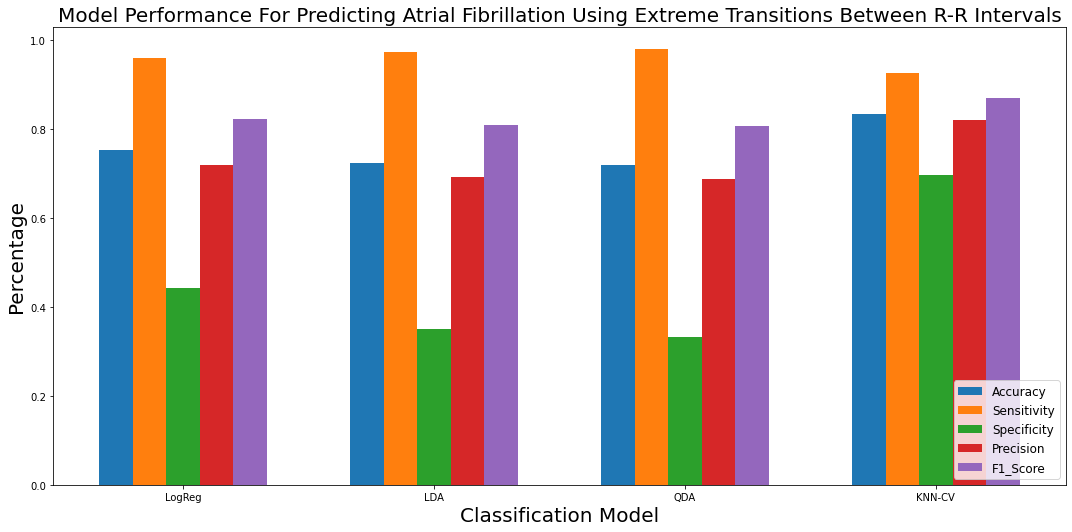

In [13]:
models = ['LogReg', 'LDA', 'QDA', 'KNN-CV']
accuracies = statextrtrans_dic["Accuracy"]
sensitivities = statextrtrans_dic["Sensitivity"]
specificities = statextrtrans_dic["Specificity"]
precisions = statextrtrans_dic["Precision"]
f1_scores = statextrtrans_dic["F1_Score"]



x = 6*np.arange(len(models))
width = 0.8

fig, ax = plt.subplots(figsize=(15, 7.5))
acc = ax.bar(x-width*2, accuracies, width, label='Accuracy')
sen = ax.bar(x-width, sensitivities, width, label='Sensitivity')
spe = ax.bar(x,specificities, width, label='Specificity')
pre = ax.bar(x+width, precisions, width, label='Precision')
f1 = ax.bar(x+width*2 , f1_scores, width, label='F1_Score')

ax.set_xlabel('Classification Model', fontsize=20)
ax.set_ylabel('Percentage', fontsize=20)
ax.set_title('Model Performance For Predicting Atrial Fibrillation Using Extreme Transitions Between R-R Intervals', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()


fig.tight_layout()

plt.legend(loc="lower right", prop={'size': 12})
plt.show()

fig.savefig('ExtremeTransitionsModel.png')

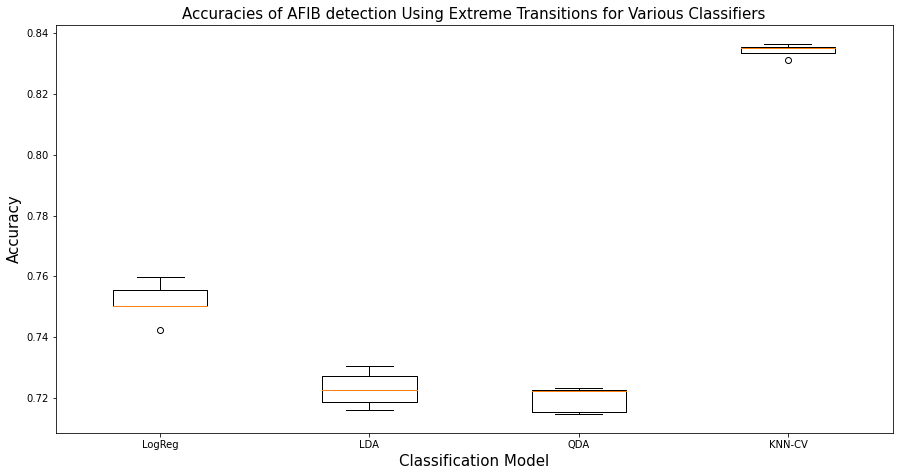

In [14]:
#Box Plots

models = ['LogReg', 'LDA', 'QDA', 'KNN-CV']

x = np.arange(len(models))+1

LogRegAcc = indaccs['LogReg']
LDAAcc = indaccs['LDA']
QDAAcc = indaccs['QDA']
KNNAcc = indaccs['KNN-CV']

data = [LogRegAcc, LDAAcc, QDAAcc, KNNAcc]

fig, ax = plt.subplots(figsize = (15,7.5))
ax.boxplot(data)

ax.set_title('Accuracies of AFIB detection Using Extreme Transitions for Various Classifiers', fontsize=15)
ax.set_xlabel('Classification Model', fontsize=15)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(models)

plt.show()

fig.savefig('ExtrTransBox.png')

In [16]:
rmsdf = pd.DataFrame(
    data = np.transpose(np.array([
                                statextrtrans_dic["Accuracy"],
                                statextrtrans_dic["Standard Error"],
                                statextrtrans_dic["Sensitivity"],
                                statextrtrans_dic["Specificity"],
                                statextrtrans_dic["Precision"],
                                statextrtrans_dic["F1_Score"],
                                statextrtrans_dic["Run Time"] 
                            ])
                       ),
    
    columns = ["Accuracy", "Standard Error", "Sensitivity", "Specificity", "Precision", "F1-Score", "Run Time"]
    
)

rmsdf.set_index(pd.Index(["LogReg", "LDA", "QDA", "KNN-CV"]))

,Accuracy,Standard Error,Sensitivity,Specificity,Precision,F1-Score,Run Time
LogReg,0.751564,0.005879,0.959075,0.442073,0.719399,0.822125,0.404516
LDA,0.723028,0.005260,0.972563,0.350864,0.690837,0.807842,0.283509
QDA,0.719639,0.003847,0.979203,0.332514,0.686318,0.807009,0.142575
KNN-CV,0.834273,0.001885,0.926490,0.696737,0.820029,0.870015,6.367444
